In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('water_quality_dataset_100k_new.csv', index_col=0)
df.head()

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
Index,,,,,,,,,,,,,,,,,,,,,
3343584,7.262136,0.002857,5.965704,245.101184,6.679537e-44,0.702867,Faint Yellow,0.014223,0.583591,0.039819,...,2.835370,8.067879e-03,153.126744,Spring,11.179752,55.340114,August,20.0,17.0,0
4332797,6.827967,0.000356,8.650092,261.948686,2.751868e-159,0.205934,Colorless,0.339881,2.214786,0.224705,...,3.228036,4.245956e-05,260.391845,Ground,12.573723,80.335206,June,26.0,2.0,1
2580354,NaN,0.000063,NaN,176.192348,NaN,0.896104,Near Colorless,0.122076,1.566183,0.058934,...,2.863932,1.646600e-03,131.984171,Reservoir,12.702576,81.535521,January,4.0,16.0,0
484305,7.782600,0.051721,3.747001,224.053938,1.513023e-136,0.088500,Colorless,0.209460,0.693032,0.393710,...,4.195383,5.283502e-11,447.051626,NaN,13.009862,72.845282,May,13.0,1.0,0
1026518,7.627800,0.000172,7.988966,89.478315,3.450032e-76,0.402281,Colorless,0.520102,1.130603,0.211742,...,4.004640,9.799640e-03,395.187898,Ground,17.727374,36.844691,December,25.0,18.0,0


In [3]:
print('shape of data :', df.shape)

shape of data : (100000, 23)


In [4]:
print('colums of data\n',df.columns)

colums of data
 Index(['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Source',
       'Water Temperature', 'Air Temperature', 'Month', 'Day', 'Time of Day',
       'Target'],
      dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 3343584 to 3456164
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   pH                      97979 non-null   float64
 1   Iron                    99328 non-null   float64
 2   Nitrate                 98204 non-null   float64
 3   Chloride                97045 non-null   float64
 4   Lead                    99571 non-null   float64
 5   Zinc                    97439 non-null   float64
 6   Color                   99901 non-null   object 
 7   Turbidity               99167 non-null   float64
 8   Fluoride                96784 non-null   float64
 9   Copper                  96785 non-null   float64
 10  Odor                    97034 non-null   float64
 11  Sulfate                 96723 non-null   float64
 12  Conductivity            97215 non-null   float64
 13  Chlorine                98992 non-null   float64
 14  Manganese         

In [6]:
df.drop(columns=["Color", "Air Temperature", "Month", "Day", "Time of Day"],axis=1,inplace=True)


In [7]:
duplicate=df[df.duplicated()]
print('count of duplicate row :', duplicate.shape[0])

count of duplicate row : 33


## Exploratory Data Analysis (EDA)

###  Analyze the 'Target' Variable

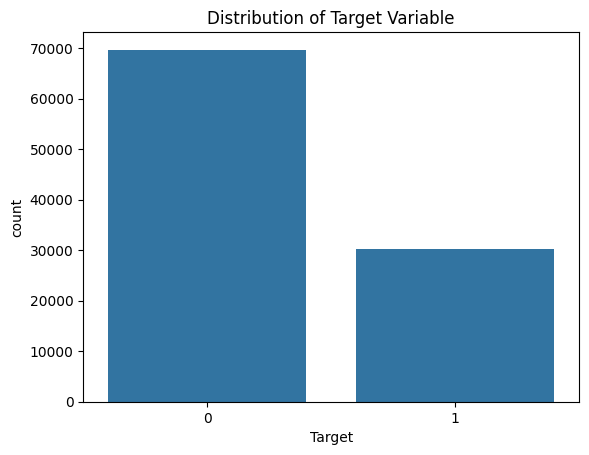

In [8]:
sns.countplot(x='Target', data=df)
plt.title('Distribution of Target Variable')
plt.show()


data is inbalance so we have to aaply smote

### Visualize Numerical and Categorical Features

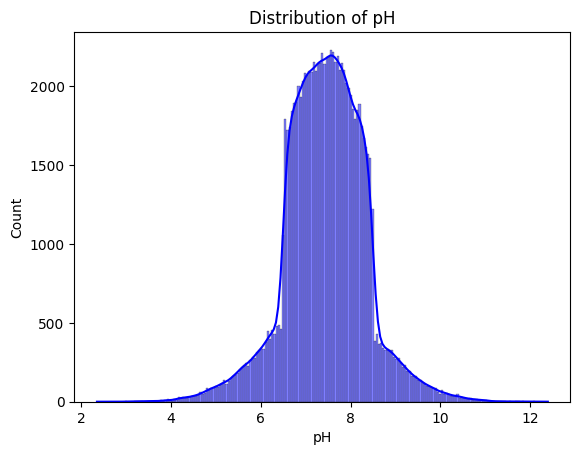

In [9]:
sns.histplot(df['pH'], kde=True, color='blue')
plt.title('Distribution of pH')
plt.show()


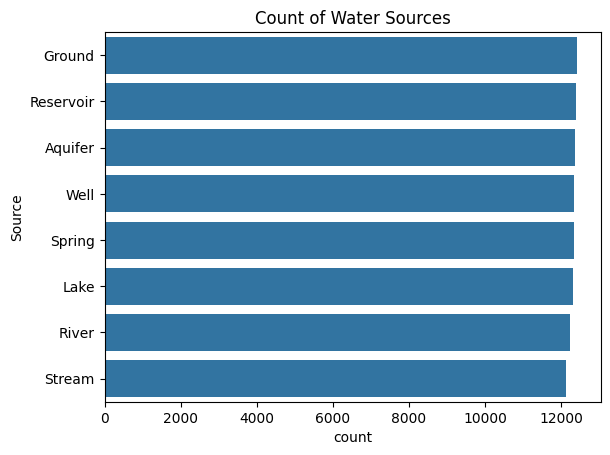

In [10]:
sns.countplot(y='Source', data=df, order = df['Source'].value_counts().index)
plt.title('Count of Water Sources')
plt.show()

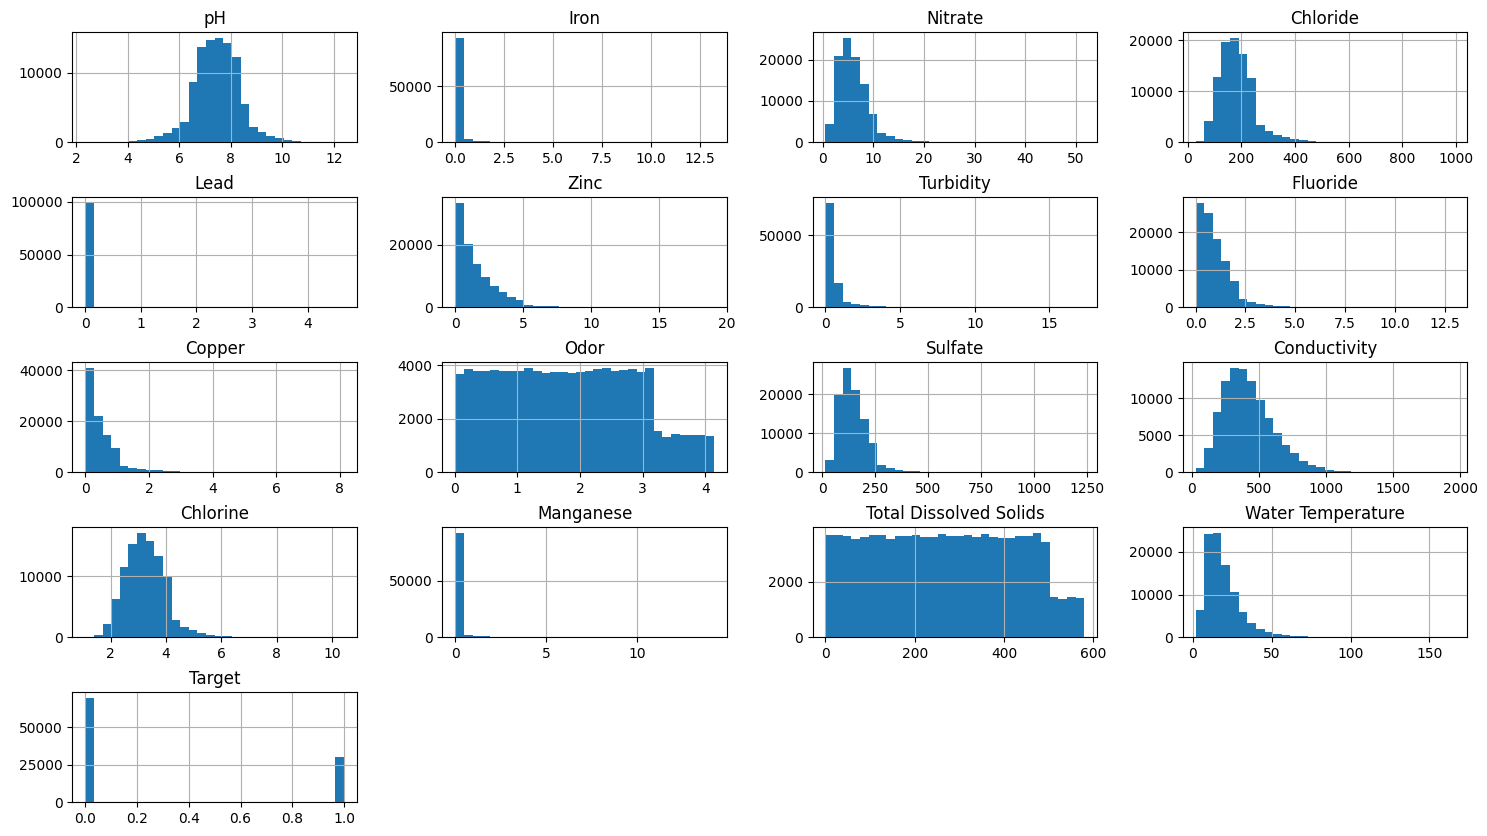

In [11]:

ax = df.hist(bins=30, figsize=(18, 10))

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()


###  Correlation Analysis

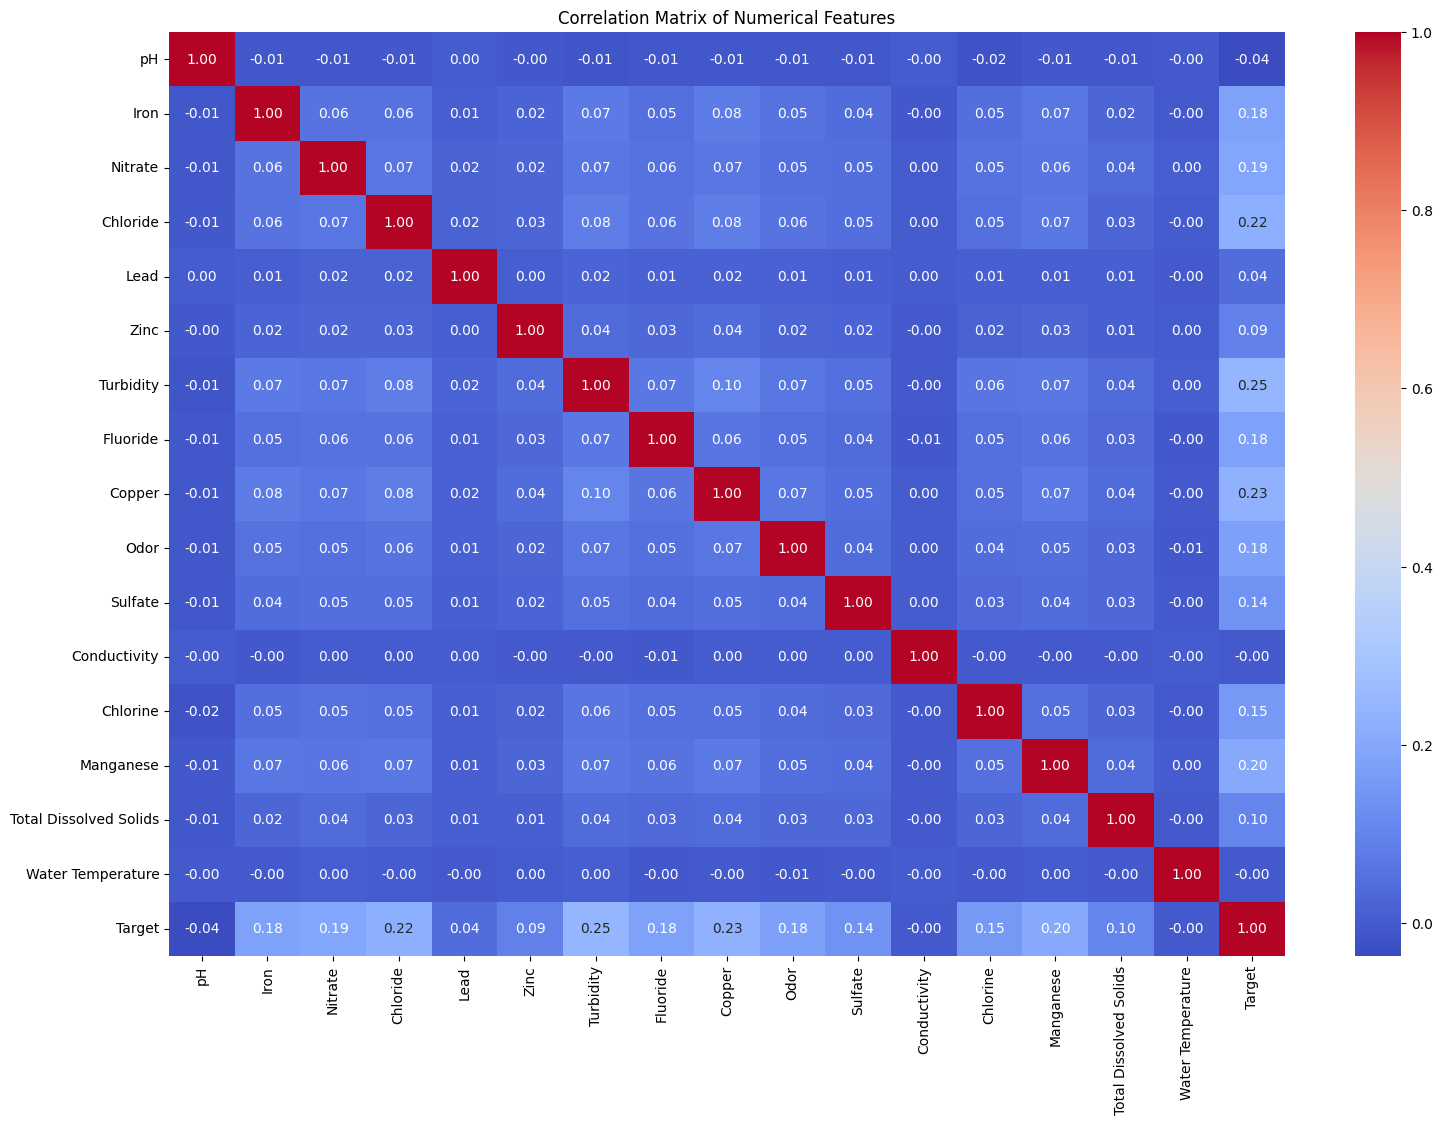

In [12]:
# Calculate the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [13]:
df.corr(numeric_only=True)['Target'].sort_values(ascending=False)

Target                    1.000000
Turbidity                 0.245629
Copper                    0.226463
Chloride                  0.223686
Manganese                 0.203520
Nitrate                   0.191189
Iron                      0.181756
Fluoride                  0.180367
Odor                      0.176709
Chlorine                  0.154816
Sulfate                   0.140007
Total Dissolved Solids    0.101182
Zinc                      0.090751
Lead                      0.041813
Conductivity             -0.002815
Water Temperature        -0.003895
pH                       -0.036872
Name: Target, dtype: float64

## Feature Engineering & Preprocessing

###  Handle Missing Values

In [14]:
df.isnull().sum()

pH                        2021
Iron                       672
Nitrate                   1796
Chloride                  2955
Lead                       429
Zinc                      2561
Turbidity                  833
Fluoride                  3216
Copper                    3215
Odor                      2966
Sulfate                   3277
Conductivity              2785
Chlorine                  1008
Manganese                 1830
Total Dissolved Solids      39
Source                    1529
Water Temperature         2810
Target                       0
dtype: int64

In [15]:
# Fill missing numerical values 
num_cols=['pH', 'Iron', 'Nitrate', 'Chloride', 'Turbidity', 'Sulfate', 'Conductivity', 'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Water Temperature','Lead','Zinc','Fluoride','Copper','Target']
   
imputer = KNNImputer(n_neighbors=5)

df[num_cols] = imputer.fit_transform(df[num_cols])


# Fill missing categorical values with the mode
for col in [ 'Odor', 'Source']:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

In [16]:
df.isna().sum()

pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Conductivity              0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Source                    0
Water Temperature         0
Target                    0
dtype: int64

### Drop Unnecessary Columns

In [17]:
df = df.drop(columns=['Source'], axis=1)

In [18]:
df.dtypes

pH                        float64
Iron                      float64
Nitrate                   float64
Chloride                  float64
Lead                      float64
Zinc                      float64
Turbidity                 float64
Fluoride                  float64
Copper                    float64
Odor                      float64
Sulfate                   float64
Conductivity              float64
Chlorine                  float64
Manganese                 float64
Total Dissolved Solids    float64
Water Temperature         float64
Target                    float64
dtype: object

###  Split Data into Features (X) and Target (y)

In [19]:
X = df.drop('Target', axis=1)
y = df['Target']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling 

In [21]:

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Training the data

We focused on four kinds of algorithms: Logistic Regression, svm, Decision Trees, Random-Forest and xg-boost predict rides cancelation. We then evaluated our models' performances using Classification Report and Confusion Matrix.

In [22]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix

### We will use SMOTE oversampling to create synthetic points

# SMOTE Oversampling

- Solving the Class Imbalance: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

- Location of the synthetic points: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

- Final Effect: More information is retained since we didn't have to delete any rows unlike in random undersampling.

- Accuracy || Time Tradeoff: Although it is likely that SMOTE will be more accurate than random under-sampling, it is more costly than undersampling methods.

In [23]:

print("Before SMOTE:", y_train.value_counts())


# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: Target
0.0    55846
1.0    24154
Name: count, dtype: int64
After SMOTE: Target
0.0    55846
1.0    55846
Name: count, dtype: int64


## 1. Logistic Regression

In [24]:
LR_model=LogisticRegression()
LR_model.fit(X_train,y_train)

pred=LR_model.predict(X_test)
print('Logistic Regression without SMOTE\n', classification_report(y_test,pred))

Logistic Regression without SMOTE
               precision    recall  f1-score   support

         0.0       0.79      0.93      0.85     13848
         1.0       0.73      0.45      0.56      6152

    accuracy                           0.78     20000
   macro avg       0.76      0.69      0.70     20000
weighted avg       0.77      0.78      0.76     20000



In [25]:
LR_model=LogisticRegression()
LR_model.fit(X_train_resampled,y_train_resampled)

pred=LR_model.predict(X_test)
print('Logistic Regression with SMOTE\n', classification_report(y_test,pred))

Logistic Regression with SMOTE
               precision    recall  f1-score   support

         0.0       0.87      0.83      0.85     13848
         1.0       0.65      0.72      0.68      6152

    accuracy                           0.79     20000
   macro avg       0.76      0.77      0.76     20000
weighted avg       0.80      0.79      0.80     20000



## SVC

In [26]:
SVC_model = SVC()
SVC_model.fit(X_train, y_train)
svc_pred = SVC_model.predict(X_test)
print("Support Vector Classifier (SVC) without SMOTE \n")
print(classification_report(y_test, svc_pred))


Support Vector Classifier (SVC) without SMOTE 

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     13848
         1.0       0.73      0.81      0.77      6152

    accuracy                           0.85     20000
   macro avg       0.82      0.84      0.83     20000
weighted avg       0.86      0.85      0.85     20000



In [27]:
SVC_model = SVC()
SVC_model.fit(X_train_resampled, y_train_resampled)
svc_pred = SVC_model.predict(X_test)
print("Support Vector Classifier (SVC) with SMOTE \n")
print(classification_report(y_test, svc_pred))


Support Vector Classifier (SVC) with SMOTE 

              precision    recall  f1-score   support

         0.0       0.94      0.85      0.90     13848
         1.0       0.73      0.89      0.80      6152

    accuracy                           0.86     20000
   macro avg       0.84      0.87      0.85     20000
weighted avg       0.88      0.86      0.87     20000



##  DecisionTreeClassifier

In [28]:
DT_model = DecisionTreeClassifier(random_state=42,max_depth=10)
DT_model.fit(X_train, y_train)
dt_pred = DT_model.predict(X_test)
print("Decision Tree Classifier without SMOTE\n")
print(classification_report(y_test, dt_pred))

Decision Tree Classifier without SMOTE

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     13848
         1.0       0.73      0.91      0.81      6152

    accuracy                           0.87     20000
   macro avg       0.84      0.88      0.85     20000
weighted avg       0.88      0.87      0.87     20000



In [29]:
DT_model = DecisionTreeClassifier(random_state=42,max_depth=10)
DT_model.fit(X_train_resampled, y_train_resampled)
dt_pred = DT_model.predict(X_test)
print("Decision Tree Classifier with SMOTE\n")
print(classification_report(y_test, dt_pred))

Decision Tree Classifier with SMOTE

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     13848
         1.0       0.73      0.91      0.81      6152

    accuracy                           0.87     20000
   macro avg       0.84      0.88      0.85     20000
weighted avg       0.89      0.87      0.87     20000



## Random Forest Classifier 


In [30]:
RF_model = RandomForestClassifier(random_state=42, n_estimators=100,max_depth=10)
RF_model.fit(X_train_resampled, y_train_resampled)


rf_pred = RF_model.predict(X_test)


print("Random Forest Classifier without SMOTE\n")
print(classification_report(y_test, rf_pred))


Random Forest Classifier without SMOTE

              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90     13848
         1.0       0.73      0.96      0.83      6152

    accuracy                           0.88     20000
   macro avg       0.85      0.90      0.87     20000
weighted avg       0.90      0.88      0.88     20000



In [33]:
from sklearn.model_selection import GridSearchCV


# Define parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=42)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                
    n_jobs=-1,        
    verbose=2,
    scoring='f1'         
)


grid_search.fit(X_train_resampled, y_train_resampled)


print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
best_rf = grid_search.best_estimator_
rf_pred = best_rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, rf_pred))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  44.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  44.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

KeyboardInterrupt: 